In [127]:
import tensorflow as tf
print(tf. __version__)

2.12.0


In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
import keras
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [130]:
train_dir = r"//content/drive/MyDrive/Dataset 100 by 100/Train/"
val_dir = r"/content/drive/MyDrive/Dataset 100 by 100/Validat/"
test_dir = r"/content/drive/MyDrive/Dataset 100 by 100/Test/"

In [131]:
IMAGE_SIZE = (100,100)
trainDataAll = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = IMAGE_SIZE,
                                                                   shuffle = True )

valDataALL = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

testDataALL = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

Found 7000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [133]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1. /255)   
])

In [134]:
y_val_labels = []
for images, labels in valDataALL.unbatch(): # unbatch the test data and get images and labels
    y_val_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [135]:
y_test_labels = []
for images, labels in testDataALL.unbatch(): # unbatch the test data and get images and labels
    y_test_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [136]:
class_names = testDataALL.class_names
class_names

['mel', 'nev']

In [137]:
# Function for Confusion Matrix
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    """
    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
     # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

   # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

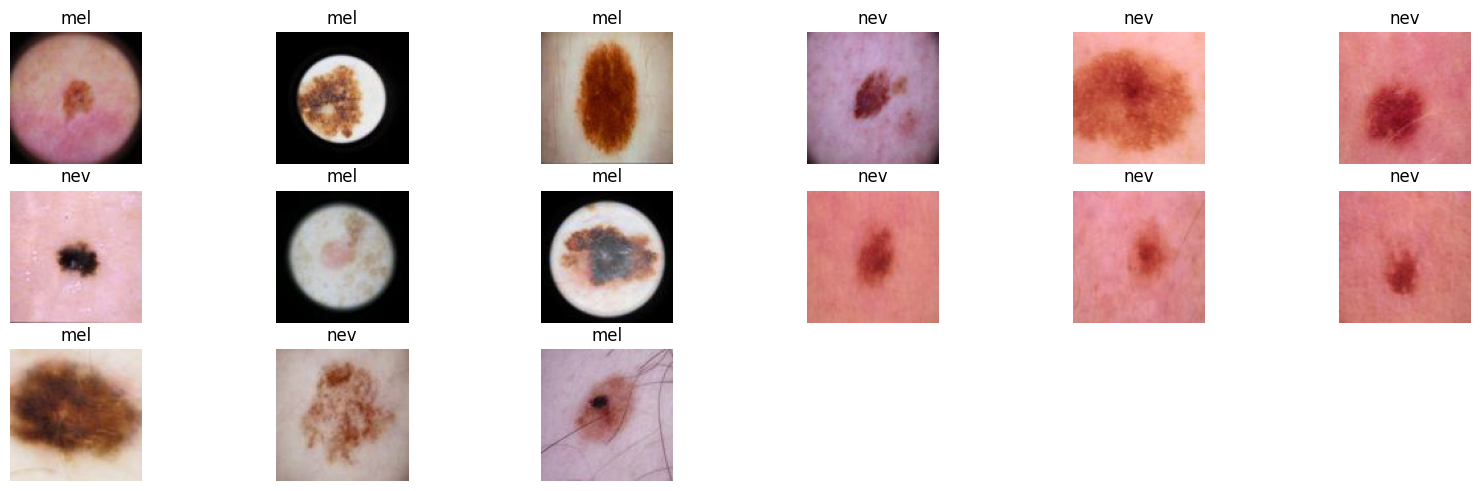

In [138]:
import os
import random
import matplotlib.image as mpimg

plt.figure(figsize = (20,12))
for i in range(15):
    ax = plt.subplot(6,6,i+1)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(train_dir + "/" + class_name))
    filepath = train_dir + class_name + "/" + filename
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)

In [139]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

def create_model(input_shape, num_classes):
    # Load VGG16 pre-trained on ImageNet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add NIN architecture on top of VGG16
    x = base_model.output
    x = Conv2D(32, (5, 5), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

   

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.9)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create new model with NIN architecture on top of VGG16
    model1 = Model(inputs=base_model.input, outputs=predictions)
    
    return model1

In [140]:
model = create_model((100, 100, 3), 2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [141]:
from keras.callbacks import ModelCheckpoint

# Create ModelCheckpoint callback to save the best model weights
checkpoint_callback = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_accuracy',
                                      save_best_only=True, mode='max')




In [142]:
history = model.fit(trainDataAll, epochs = 30,
                     batch_size = 32,
                     validation_data = valDataALL,
                     validation_steps = len(valDataALL),
                    callbacks=[checkpoint_callback])

Epoch 1/30
219/219 [==============================] - 540s 2s/step - loss: 0.3212 - accuracy: 0.8499 - val_loss: 0.4484 - val_accuracy: 0.7900
Epoch 2/30
219/219 [==============================] - 11s 50ms/step - loss: 0.1969 - accuracy: 0.9196 - val_loss: 0.6978 - val_accuracy: 0.7470
Epoch 3/30
219/219 [==============================] - 10s 45ms/step - loss: 0.1629 - accuracy: 0.9361 - val_loss: 0.4390 - val_accuracy: 0.7860
Epoch 4/30
219/219 [==============================] - 11s 47ms/step - loss: 0.1164 - accuracy: 0.9546 - val_loss: 0.6852 - val_accuracy: 0.7790
Epoch 5/30
219/219 [==============================] - 11s 49ms/step - loss: 0.0992 - accuracy: 0.9610 - val_loss: 0.6992 - val_accuracy: 0.7900
Epoch 6/30
219/219 [==============================] - 11s 51ms/step - loss: 0.0833 - accuracy: 0.9701 - val_loss: 0.9645 - val_accuracy: 0.7720
Epoch 7/30
219/219 [==============================] - 10s 46ms/step - loss: 0.0720 - accuracy: 0.9741 - val_loss: 0.9727 - val_accuracy: 

In [143]:

y_pred1 = model.predict(testDataALL)

63/63 [==============================] - 2s 35ms/step


In [144]:
model.evaluate(testDataALL)

63/63 [==============================] - 2s 36ms/step - loss: 1.9459 - accuracy: 0.9005


[1.945913314819336, 0.9004999995231628]

In [145]:
from sklearn.metrics import accuracy_score
import numpy as np
sklearn_accuracy = accuracy_score(y_test_labels, np.argmax(y_pred1, axis = 1))
print('Accuracy of NIN MODEL on Test Data:', sklearn_accuracy)

Accuracy of NIN MODEL on Test Data: 0.9005


In [146]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, np.argmax(y_pred1, axis = 1), target_names=class_names))

              precision    recall  f1-score   support

         mel       0.93      0.87      0.90      1000
         nev       0.88      0.93      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



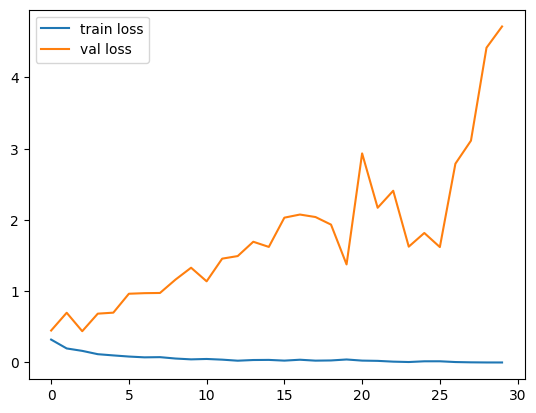

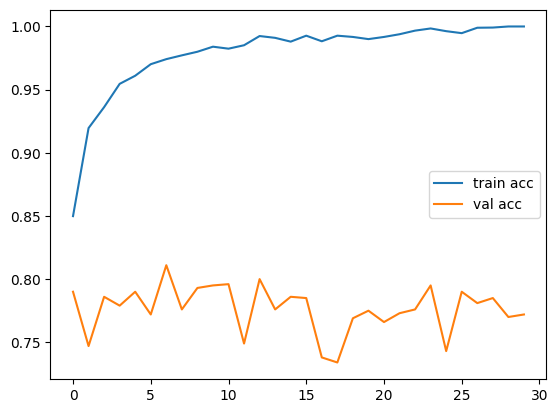

In [154]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc' )
plt.plot(history.history['val_accuracy'], label='val acc' )
plt.legend()
plt.show()


 
# plt.savefig('AccVal_acc')

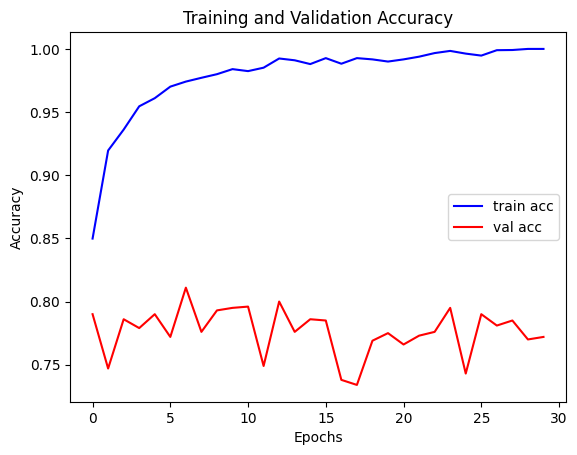

In [155]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy curves in different colors
plt.plot(history.history['accuracy'], label='train acc', color='blue')
plt.plot(history.history['val_accuracy'], label='val acc', color='red')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

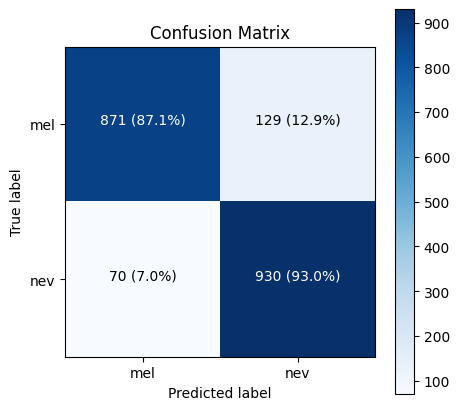

In [148]:
# Confusion Matrix
make_confusion_matrix(y_true=y_test_labels, # ground truth test labels
                          y_pred=np.argmax(y_pred1, axis = 1), # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(5, 5),
                          text_size=10)

In [149]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   